# ** Neural Network for MNIST Dataset **

NN for the Iris dataset using keras and backpropagation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

from IPython.display import SVG
from keras.utils import model_to_dot
import pydot

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

2.1.0


Using TensorFlow backend.


In [3]:
# The digits dataset
digits = load_digits()
X = digits['data'] # (1797, 64), 1797 digits, 64 pixels per 8x8 image
y = digits['target'] # 1797 labels of 0-9
print(y.shape)
images = digits['images'] # (1797, 8, 8) dataset
names = digits['target_names'] # [0 1 2 3 4 5 6 7 8 9]

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()
print("Big Y = {}".format(Y.shape))

#preprocess: scale between 0 and 1
X /= 16.0
images /= 16.0

(1797,)
Big Y = (1797, 10)


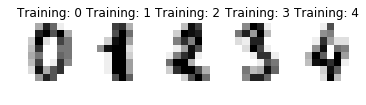

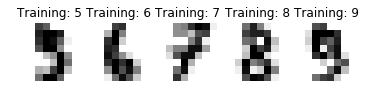

In [4]:
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(1, 5)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes, images_and_labels[:5]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)
_, axes = plt.subplots(1, 5)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes, images_and_labels[5:10]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [9]:
# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(images, y, test_size=0.2, random_state=2)
print("X_train shape = {}".format(X_train.shape))
print("Y_train shape = {}".format(Y_train.shape))
print("X_test shape = {}".format(X_test.shape))
print("Y_test shape = {}".format(Y_test.shape))

n_samples = X.shape[0]
print("no. samples = {}".format(n_samples))
n_classes = Y.shape[1]
print("no. classes = {}".format(n_classes))

X_train shape = (1437, 8, 8)
Y_train shape = (1437,)
X_test shape = (360, 8, 8)
Y_test shape = (360,)
no. samples = 1797
no. classes = 10


In [10]:
def build_model():
    
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(8, 8)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', 'mae', 'mse'])
    return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 9,610
Trainable params: 9,610
Non-trainable params: 0
_________________________________________________________________


## Train the full model

#### Epochs
This is the number of times the network trains forwards and backwards, we will leave this as a high number as we implement early stopping.

#### History
History saves the model fitting data allowing us to plot and visualise it.

#### Validation split
The validation split: If you set the validation_split argument in model.fit to e.g. 0.1, then the validation data used will be the last 10% of the data. Note that the data isn't shuffled before extracting the validation split, so the validation is literally just the last x% of samples in the input you passed. Used to validate as you train.

In [11]:
EPOCHS = 50

history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size = 32, validation_split = 0.2,
                    verbose=0 , callbacks=[ tfdocs.modeling.EpochDots()] )


Epoch: 0, accuracy:0.2472,  loss:2.2752,  mae:4.4770,  mse:28.2074,  val_accuracy:0.5521,  val_loss:2.2457,  val_mae:4.6996,  val_mse:30.8153,  
..................................................

History is a dataframe, we can print the tail of this for the last 5 epochs to see what data we collect at each epoch.

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,mae,mse,val_loss,val_accuracy,val_mae,val_mse,epoch
45,0.177604,0.963446,7.627972,76.373940,0.214572,0.940972,7.843082,80.219574,45
46,0.173360,0.964317,7.663134,77.081955,0.209863,0.940972,7.882885,81.148666,46
47,0.169082,0.961706,7.702013,77.849396,0.205403,0.947917,7.919901,81.926544,47
48,0.165227,0.961706,7.739846,78.715981,0.202140,0.947917,7.959125,82.706573,48
49,0.162151,0.965187,7.774918,79.319046,0.198872,0.947917,7.997946,83.596458,49


We can plot the mean absolute error for the training data and the validation data. When the validation data levels off our model is no longer improving.

Text(0, 0.5, 'MSE')

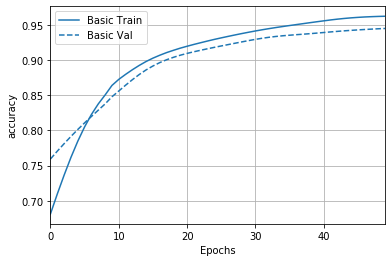

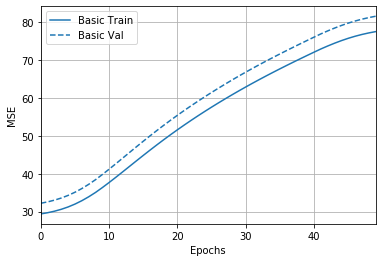

In [13]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "accuracy")
# plt.ylim([0, 1])
plt.ylabel('accuracy')

plt.figure()
plotter.plot({'Basic': history}, metric = "mse")
# plt.ylim([0, 1])
plt.ylabel('MSE')

## Testing the model

We now used this learnt model to predict outputs using our test inputs.

We note that y_test are the real output values that match the inputs X_test.

In [14]:
test_loss, test_acc, test_mae, test_mse = model.evaluate(X_test, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

360/360 - 0s - loss: 0.2982 - accuracy: 0.9306 - mae: 7.7694 - mse: 79.0803

Test accuracy: 0.9305556

Test loss: 0.29823736995458605


### Make predictions

With the model trained, you can use it to make predictions about some images. The model's linear outputs, logits. Attach a softmax layer to convert the logits to probabilities, which are easier to interpret.

In [15]:
probability_model = keras.Sequential([model, keras.layers.Softmax()])
predictions = probability_model.predict(X_test)

In [16]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(names[predicted_label],
                                100*np.max(predictions_array),
                                names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

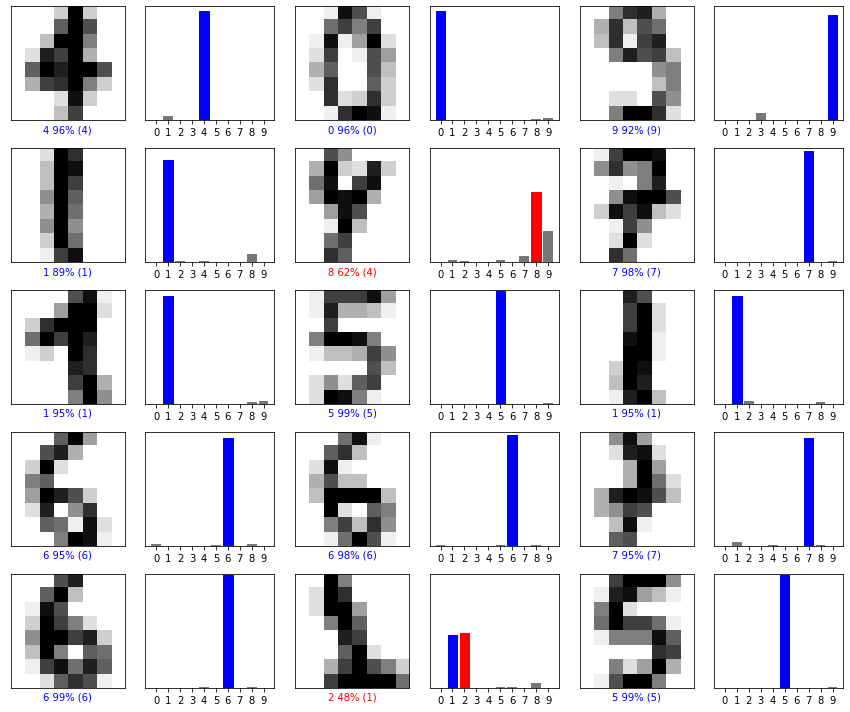

In [17]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], Y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], Y_test)
plt.tight_layout()
plt.show()

In [8]:
ls_form = []
my_weights = model.get_weights()
index = 0
for comp in my_weights:
    ls_form.append([index, index + np.size(comp), comp.shape])
    index += np.size(comp)

In [9]:
def Convert(pre_w):
    position = []
    for w in pre_w:
        position.append(w.flatten())
    return np.concatenate(position)

In [10]:
def f(positions):
    if positions.ndim == 1:
        positions = positions.reshape([1, positions.shape[0]])
    global model, X_train, Y_train
    objective = np.zeros([positions.shape[0], 1])
    for part_ind, part_pos in enumerate(positions):
        x_1 = ConvertBack(part_pos)
        model.set_weights(x_1)
        objective[part_ind] = model.evaluate(X_train, Y_train, verbose=0)
    return objective

In [11]:
#define swarm
n_particles = 20
n_dims = Convert(model.get_weights()).shape[0]

#define parameters
x_min = -0.5
x_max = 0.5
v_min = 0
v_max = 0.01
c_1 = 2
c_2 = 2

# Set the initial conditions
current_pos = x_min + (x_max-x_min)*np.random.rand(n_particles, n_dims) #initialise the particles
p_best = current_pos                                                    #set the particle best
g_best = p_best[np.argmin(f(current_pos)),:];                           #get the best location

v = v_min + (v_max-v_min)*np.random.rand(n_particles, n_dims)

is_better = np.zeros([n_particles,1])

NameError: name 'ConvertBack' is not defined